This tutorial refers to using the `fmi` library which can be found [here](https://github.com/asvcode/fmi) and the [fastai](https://github.com/fastai) medical imaging module

## Goal

This dataset contains over 33000 images. The goal of this tutorial is to use both the `fastai` medical imaging library and the `fmi` library in order to create a quick baseline

- Create a dicom metadata dataframe from the images (using `from_dicoms2`)

- Within each folder(which represents each patient) we will choose 5 images that represent the best representation of the patient based on what window level and width

- Transfer the choosen images per patient into a seperate folder (using `move_files`)

- Create masks that reduce the overall size of the images to areas that are important (based on the window level and width) and save them in `.png` format

From this

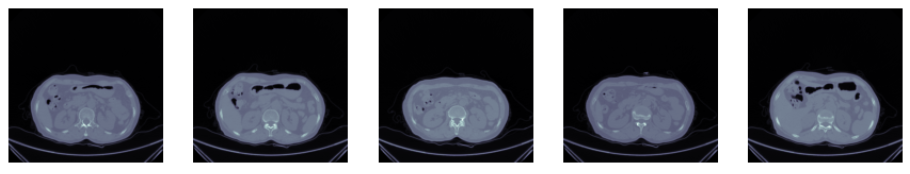

to this

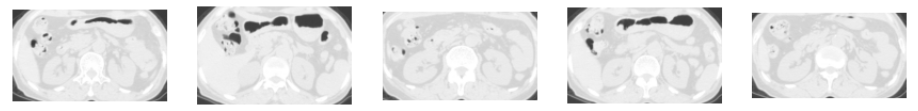[](http://)

## Dependancies

Install the `gdcm` library - use the `pe-models database` to access gdcm.tar file

In [ ]:
!cp ../input/pe-models/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
print("done")

import libraries

In [ ]:
from fastai.torch_core import set_seed
from fastai.vision.all import *
from fastai.medical.imaging import *
from torchvision.utils import save_image

import gdcm
matplotlib.rcParams['image.cmap'] = 'bone'

import matplotlib as plt
plt.rcParams.update({'figure.max_open_warning': 0})

Currently the `fmi` package is still under construction and not pip installable. Instead install via the `fmipackage` dataset

In [ ]:
!cp -r ../input/fmipackage/fmi-master/* ./

In [ ]:
from fmi.explore import *
from fmi.preprocessing import *
from fmi.pipeline import *

In [ ]:
source = '../input/osic-pulmonary-fibrosis-progression'
os_items = get_dicom_files(source, folders='train')
os.listdir(source)

## Create the dicom dataframe

Uncomment the lines below to create the `dicom_database` using the updated `from_dicom2` function.  The updated function allows you to specify the window width and centre.

> Note: The next couple of cells produce the .csv file and the updated images but for convenince this can be accessed via the `pct_5` dataset

In [ ]:
#Uncomment to get the dicom metadata as a dataframe
#dicom_dataframe = pd.DataFrame.from_dicoms2(os_items, windows=dicom_windows.lungs)

In [ ]:
#Uncomment to save the generated dataframe as a .csv file
#dicom_dataframe.to_csv('dicom_dataframe.csv', index=False)

Load the `.csv` file

In [ ]:
dicom_dataframe = pd.read_csv('../input/pct-5/dicom_dataframe.csv', low_memory=False)

Sort the dataframe by `img_pct_window` and group by `PatientID`

In [ ]:
sort_w5 = dicom_dataframe.sort_values(['img_pct_window'],ascending=False).groupby('PatientID').head(5)
sort_w5

In this dataset each patient is distinguised by a unique `PatientID`.  Lets check to see how many unique patients there are in this dataset

In [ ]:
unique_pats = sort_w5['PatientID'].unique().tolist()
len(unique_pats)

## Move Files

This dataset contains over 33000 images so in order to create a quick smaller dataset for testing we will use `move_files`.  For each unique patient we sort the best values based no `img_pct_window` and move the 5 best images to another folder

In [ ]:
for i in unique_pats:
    k = sort_w5[sort_w5['PatientID']==i].sort_values(by=['img_pct_window'], ascending=False)
    #k_one = k[:5
    move_files(k, source=source, save_path='./test_5/')

Grab the saved files - we now only have 880 (5 for each patient)

In [ ]:
test_source = Path('./test_5/')
test_5 = get_dicom_files(test_source)
test_5

`mask_and_save_path` works out of the box but we just have to make a slight adjustment to how the file_name is generated whilst saving

In [ ]:
def mask_and_save_path(file: (L), source=None, show=False, window=dicom_windows.lungs, sigma:float=0.1,\
                  thresh:float=0.9, save=False, save_path=None):
    "Helper to create masks based on dicom window with the option to save the updated image from path"
    image_list = []
    for i in file:
        ##This line will have to be changed depending on what platform is being used
        #str_file = str(i); file_name = str_file.split('.')[0].split('\\')[-1] #windows
        str_file = str(i); file_name = str_file.split('/')[-1].split('.')[0] #kaggle
        dcm = dcmread(i)
        wind = dcm.windowed(*window)
        mask = dcm.mask_from_blur(window, sigma=sigma, thresh=thresh, remove_max=False)
        bbs = mask2bbox(mask)
        lo,hi = bbs
        imh = wind[lo[0]:hi[0],lo[1]:hi[1]]
        if save is not False:
            if not os.path.exists(save_path):
                os.makedirs(save_path)   
            save_image(imh, f'{save_path}/{file_name}.png')
        else:
            pass
        image_list.append(imh)
    if show is not False:
        show_images(image_list[:10], nrows=1)
    else:
        pass

Specify a save path for the saved files and use `mask_and_save_path` to save the images

In [ ]:
save_path = './mask'

In [ ]:
for folder in os.listdir('./test_5'):
    files = get_dicom_files(f'./test_5/{folder}')
    mask_and_save_path(files, window=dicom_windows.lungs, sigma=0.1, show=True, save=True, save_path=f'{save_path}/{folder}/')
    

Load the saved images

In [ ]:
mask_files = './mask'
mask_items = get_image_files(mask_files)
mask_items

and check to see what one looks like

In [ ]:
PILImage.create(mask_items[0])

## See the difference

Lets check out the difference between the original image and the saved images

### Original Images

In [ ]:
original_id = get_dicom_files('./test_5/ID00285637202278913507108')
original_id

In [ ]:
img_list=[]
for image in original_id:
    im = PILDicom.create(image); img_list.append(im)
show_images(img_list)

### Saved Images

In [ ]:
saved_id = get_image_files('./mask/ID00285637202278913507108')
saved_id

In [ ]:
img_list=[]
for image in saved_id:
    im = PILImage.create(image); img_list.append(im)
show_images(img_list)

You can see that the mask function is efficient in getting rid of areas of the image that are not important for the training process

For more about the `fmi` library: [view on Github](https://github.com/asvcode/fmi)